# Manipulating DataFrames with Pandas - Part 3 : Case Study

In this case study, we'll explore Olympic Game data from [The Guardian Data Blog](https://www.theguardian.com/sport/datablog/2012/jun/25/olympic-medal-winner-list-data).

In [57]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('data/olympic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29216 entries, 0 to 29215
Data columns (total 10 columns):
City            29216 non-null object
Edition         29216 non-null int64
Sport           29216 non-null object
Discipline      29216 non-null object
Athlete         29216 non-null object
NOC             29216 non-null object
Gender          29216 non-null object
Event           29216 non-null object
Event_gender    29216 non-null object
Medal           29216 non-null object
dtypes: int64(1), object(9)
memory usage: 2.2+ MB


In [18]:
df.head()

,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
0,Athens,1896,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100m freestyle,M,Gold
1,Athens,1896,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100m freestyle,M,Silver
2,Athens,1896,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100m freestyle for sailors,M,Bronze
3,Athens,1896,Aquatics,Swimming,"MALOKINIS, Ioannis",GRE,Men,100m freestyle for sailors,M,Gold
4,Athens,1896,Aquatics,Swimming,"CHASAPIS, Spiridon",GRE,Men,100m freestyle for sailors,M,Silver


In [19]:
# the total number of medals awarded to Turkey per edition
TUR_edition_grouped = df.loc[df.NOC == 'TUR'].groupby('Edition')
TUR_edition_grouped['Medal'].count()

Edition
1936     2
1948    12
1952     3
1956     7
1960     9
1964     6
1968     2
1972     1
1984     3
1988     2
1992     6
1996     6
2000     5
2004    10
2008     8
Name: Medal, dtype: int64

Just to compare: below is the result for the USA.

In [20]:
USA_edition_grouped = df.loc[df.NOC == 'USA'].groupby('Edition')
USA_edition_grouped['Medal'].count()

Edition
1896     20
1900     55
1904    394
1908     63
1912    101
1920    193
1924    198
1928     84
1932    181
1936     92
1948    148
1952    130
1956    118
1960    112
1964    150
1968    149
1972    155
1976    155
1984    333
1988    193
1992    224
1996    260
2000    248
2004    264
2008    315
Name: Medal, dtype: int64

We'll use `.value_counts()` method for **ranking**.

In [21]:
# Select the 'NOC (Name of the Country)' column of df
country_names = df['NOC']

# Count the number of medals won by each country
medal_counts = country_names.value_counts()

# Top 15 countries ranked by medals
medal_counts.head(15)

USA    4335
URS    2049
GBR    1594
FRA    1314
ITA    1228
GER    1211
AUS    1075
HUN    1053
SWE    1021
GDR     825
NED     782
JPN     704
CHN     679
RUS     638
ROU     624
Name: NOC, dtype: int64

In [22]:
# Medal counts of Turkey
medal_counts['TUR']

82

Counting medals by type with `.pivot_table()` method.

In [25]:
# Construct the pivot table
counted = df.pivot_table(values='Athlete', index='NOC', columns='Medal', aggfunc='count')

# Create the new column 'totals'
counted['totals'] = counted.sum(axis='columns')

# Sort counted by the 'totals' column
counted = counted.sort_values('totals', ascending=False)

# Print the top 5 rows of counted
counted.head(5)

Medal,Bronze,Gold,Silver,totals
NOC,,,,
USA,1052.0,2088.0,1195.0,4335.0
URS,584.0,838.0,627.0,2049.0
GBR,505.0,498.0,591.0,1594.0
FRA,475.0,378.0,461.0,1314.0
ITA,374.0,460.0,394.0,1228.0


In [32]:
counted.loc['TUR']

Medal
Bronze    22.0
Gold      37.0
Silver    23.0
totals    82.0
Name: TUR, dtype: float64

Let's investigate the columns.

In [34]:
df.columns

Index(['City', 'Edition', 'Sport', 'Discipline', 'Athlete', 'NOC', 'Gender',
       'Event', 'Event_gender', 'Medal'],
      dtype='object')

_Gender_ and _Event Gender_ appears to be the same. We need to further look at those columns.

In [42]:
# Select columns
df[['Gender', 'Event_gender']].sample(5)

,Gender,Event_gender
13693,Men,X
16064,Women,W
22610,Women,W
499,Men,M
25444,Men,M


There are many duplicates. The duplicates can be dropped using the `.drop_duplicates()` method, leaving behind the unique observations. 

In [43]:
# Drop duplicate pairs
gen_uniques = df[['Gender', 'Event_gender']].drop_duplicates()

gen_uniques

,Gender,Event_gender
0,Men,M
348,Men,X
416,Women,W
639,Women,X
23675,Men,W


There are possible errors in some observations.

In [45]:
# Group medals by the two columns
medals_by_gender = df.groupby(['Gender', 'Event_gender'])

# Create a DataFrame with a group count
medal_count_by_gender = medals_by_gender.count()

# Print medal_count_by_gender
medal_count_by_gender

City  Edition  Sport  Discipline  Athlete    NOC  Event  \
Gender Event_gender                                                             
Men    M             20067    20067  20067       20067    20067  20067  20067   
       W                 1        1      1           1        1      1      1   
       X              1653     1653   1653        1653     1653   1653   1653   
Women  W              7277     7277   7277        7277     7277   7277   7277   
       X               218      218    218         218      218    218    218   

                     Medal  
Gender Event_gender         
Men    M             20067  
       W                 1  
       X              1653  
Women  W              7277  
       X               218

There seems to be only one suspicious row: 'Gender->Men, Event_Gender->W'.

In [48]:
# Create a DataFrame with the suspicious row
suspect = df[(df.Event_gender == 'W') & (df.Gender == 'Men')
]

# Print suspect
suspect

,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
23675,Sydney,2000,Athletics,Athletics,"CHEPCHUMBA, Joyce",KEN,Men,marathon,W,Bronze


[Joyce Chepchumba](https://en.wikipedia.org/wiki/Joyce_Chepchumba) is actually a woman; however, she was recorded as _Men_ in the dataset.

----

We can rank countries by medals in distinct sports using `.nunique()` method. This method returns the # of distint categories in a given Series.

In [52]:
# Group medals by 'NOC'
country_grouped = df.groupby('NOC')

# Compute the number of distinct sports in which each country won medals
num_sports = country_grouped['Sport'].nunique()

# Sort the values of Nsports in descending order
num_sports = num_sports.sort_values(ascending=False)

num_sports.head(5)

NOC
USA    34
GBR    31
FRA    28
GER    26
CHN    24
Name: Sport, dtype: int64

The USSR was the second country in terms of total number of medals won. Nevertheless, it is not in the top 5 in this category. 

Let's compare the medal counts of USA vs. USSR more closely.

In [54]:
# Extract all rows for which the 'Edition' is between 1952 & 1989
during_cold_war = (df['Edition'] >= 1952) & (df['Edition'] <= 1989)

# Extract rows for which 'NOC' is either 'USA' or 'URS'
is_usa_urs = df.NOC.isin(['USA', 'URS'])

# Use during_cold_war and is_usa_urs to create the DataFrame
cold_war_medals = df.loc[during_cold_war & is_usa_urs]

# Group cold_war_medals by 'NOC'
country_grouped = cold_war_medals.groupby('NOC')

# Create num_sports
num_sports = country_grouped['Sport'].nunique().sort_values(ascending=False)

# Print num_sports
num_sports


NOC
URS    21
USA    20
Name: Sport, dtype: int64

The number of distinct sport in which USSR won medal is higher than that of the US when we look only at the Olympic competitions in the Cold War era.

---

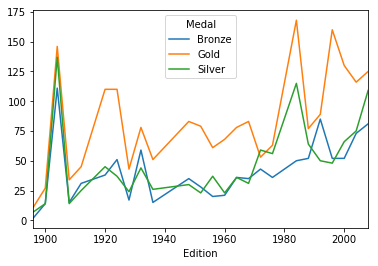

In [60]:
# Create the DataFrame
usa = df.loc[df['NOC']=='USA']

# Group usa by ['Edition', 'Medal'] and aggregate over 'Athlete'
usa_medals_by_year = usa.groupby(['Edition', 'Medal'])['Athlete'].count()

# Reshape usa_medals_by_year by unstacking
usa_medals_by_year = usa_medals_by_year.unstack(level='Medal')

# Plot the DataFrame usa_medals_by_year
usa_medals_by_year.plot()
plt.show()

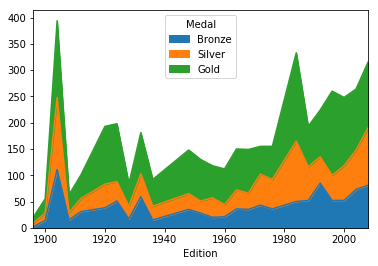

In [63]:
# Redefine 'Medal' as an ordered categorical
df.Medal = pd.Categorical(values=df.Medal, categories=['Bronze', 'Silver', 'Gold'], ordered=True)

# Create the DataFrame
usa = df[df.NOC == 'USA']

# Group usa by 'Edition', 'Medal', and 'Athlete'
usa_medals_by_year = usa.groupby(['Edition', 'Medal'])['Athlete'].count()

# Reshape usa_medals_by_year by unstacking
usa_medals_by_year = usa_medals_by_year.unstack(level='Medal')

# Create an area plot of usa_medals_by_year
usa_medals_by_year.plot.area()
plt.show()